In [ ]:
import torch
from torch.cuda.amp import autocast

# Feature Extractor

In [ ]:
!export CUDA_HOME=/usr/local/cuda-11.7
!export LD_LIBRARY_PATH=/usr/local/cuda-11.7/lib
!nvcc -V

In [ ]:
from model.pvcnn_generation import PVCNNFeatures
import torch

In [ ]:
model = PVCNNFeatures(input_dim=3, extra_feature_channels=0).cuda()

In [ ]:
test = torch.randn(3, 3, 2048*8)

In [ ]:
feats = model(test.cuda())

In [ ]:
for f in feats:
    print(f.shape)

# RIN

In [ ]:
from model.recurrent_interface_network import RIN
import torch

In [ ]:
model = RIN(
    dim = 256,                  # model dimensions
    image_size = 128,           # image size
    patch_size = 8,             # patch size
    depth = 6,                  # depth
    num_latents = 128,          # number of latents. they used 256 in the paper
    dim_latent = 512,           # can be greater than the image dimension (dim) for greater capacity
    latent_self_attn_depth = 4, # number of latent self attention blocks per recurrent step, K in the paper
).cuda()

In [ ]:
training_images = torch.randn(8, 3, 128, 128).cuda()
time = torch.rand(8).cuda()

out = model(training_images, time)

In [ ]:
from model.recurrent_pointcloud_network import RINBlock, RIN
import torch

In [ ]:
block = RINBlock(pc_dim=3, latent_self_attn_depth=6, dim_latent=256)
patches = torch.randn(3, 2048, 3)
latents = torch.zeros(3, 768, 256)
t = torch.randn(3)

out = block(patches=patches, latents=latents, t=t)

In [ ]:
model = RIN(in_dim=6,out_dim=3, depth=6, latent_self_attn_depth=6, dim_latent=256, num_latents=768).cuda()

In [ ]:
test_cloud = torch.randn(3, 2048, 3).cuda()
test_time = torch.randn(3).cuda()
out = model(test_cloud, test_time)

# Gridding

In [ ]:
import open3d as o3d
import numpy as np

cloud = "../3d/421378.ply"

pc = o3d.io.read_point_cloud(cloud)
pcnpy = np.asarray(pc.points)

In [ ]:
pcnpy.shape

In [ ]:
point_cloud = pcnpy
# substract center
point_cloud -= np.mean(point_cloud, axis=0)

In [ ]:
results[3]

# Diffusion

In [1]:
from model.diffusion_lucid import GaussianDiffusion
from omegaconf import OmegaConf
import numpy as np

Using /home/mathi/.cache/torch_extensions/py310_cu117 as PyTorch extensions root...
Using /home/mathi/.cache/torch_extensions/py310_cu117 as PyTorch extensions root...
No modifications detected for re-loaded extension module _pvcnn_backend, skipping build step...
Loading extension module _pvcnn_backend...


In [2]:
cfg_path = "configs/pvd_arkit.yml"
cfg = OmegaConf.load(cfg_path)
cfg.diffusion.num_timesteps = 1000

diffusion = GaussianDiffusion(cfg)

In [4]:
import point_cloud_utils as pcu
import pyminiply

In [5]:
ply_path = "../3d/mesh_aligned_0.05.ply"
ply, *_ = pyminiply.read(ply_path)
pcd = ply
pcd.shape

(775088, 3)

In [7]:
a = np.random.rand(10000, 3)
b = np.random.rand(10000, 3)

chamfer_dist = pcu.chamfer_distance(a, b)
chamfer_dist

0.0522542270410832

In [468]:
ply_path = "../3d/mesh_aligned_0.05.ply"
ply = pcu.load_mesh_v(ply_path)
pcd = ply
pcd.shape

(775088, 3)

In [10]:
import scipy

pcd_tree = scipy.spatial.cKDTree(ply)

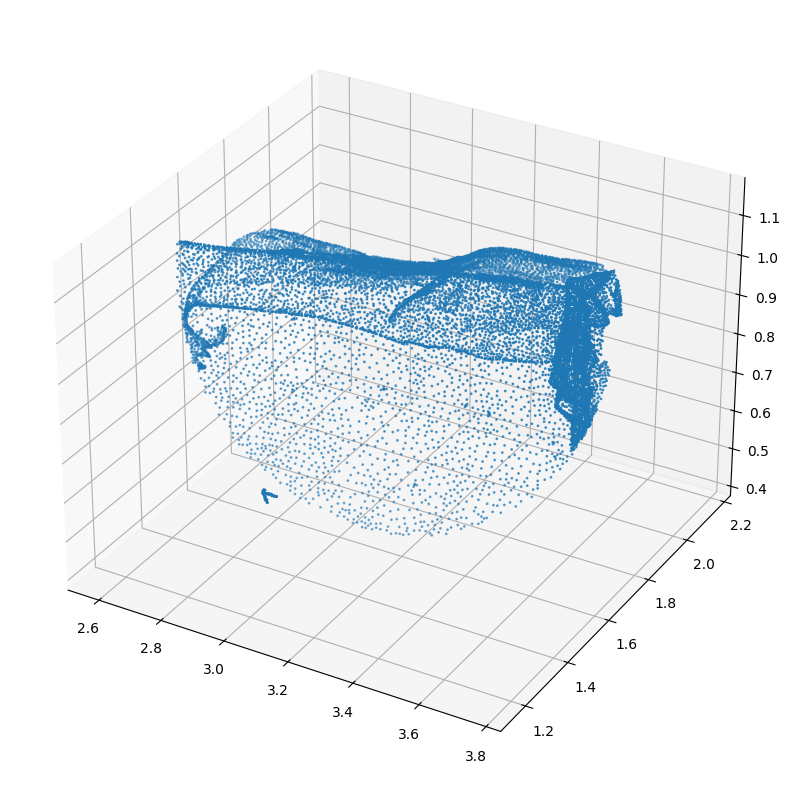

In [13]:
rand_idx = np.random.randint(0, len(ply))   
k_nearest = pcd_tree.query(ply[rand_idx], 16000)[1]
x = pcd[k_nearest]

# plot point cloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=1)
plt.show()

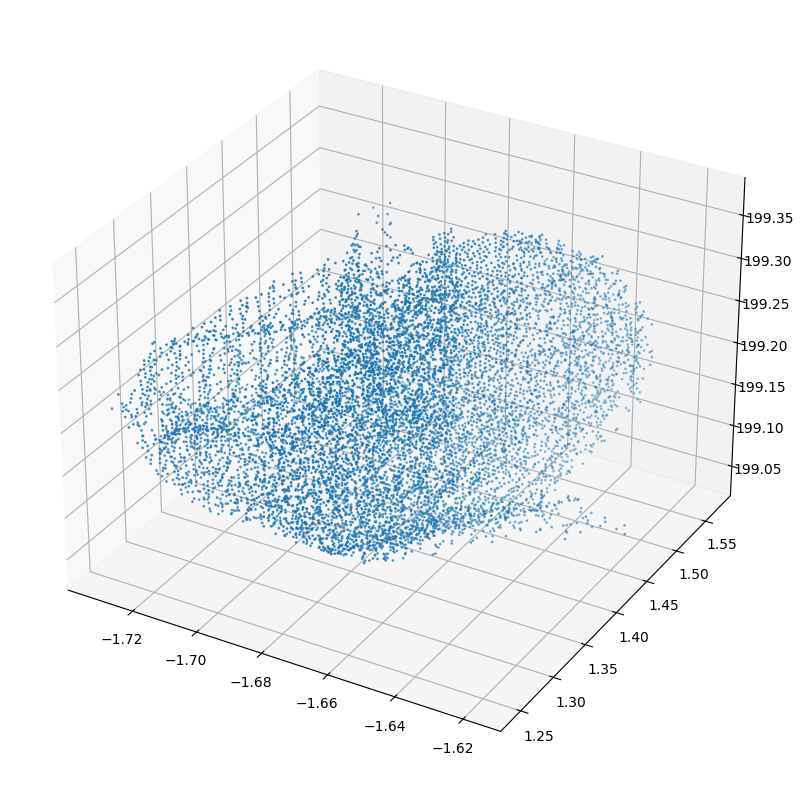

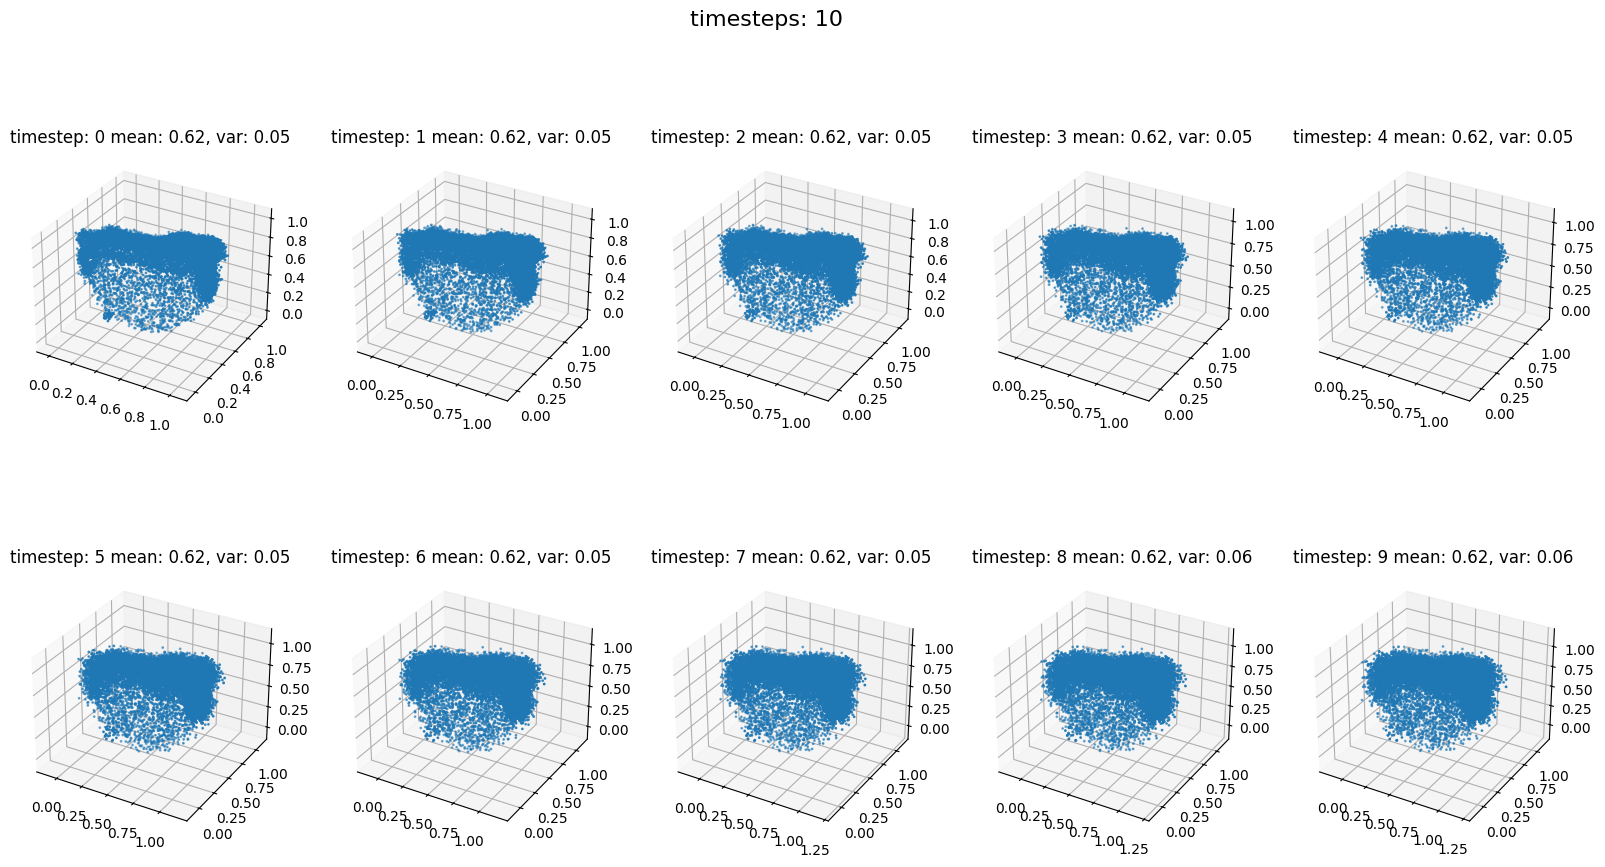

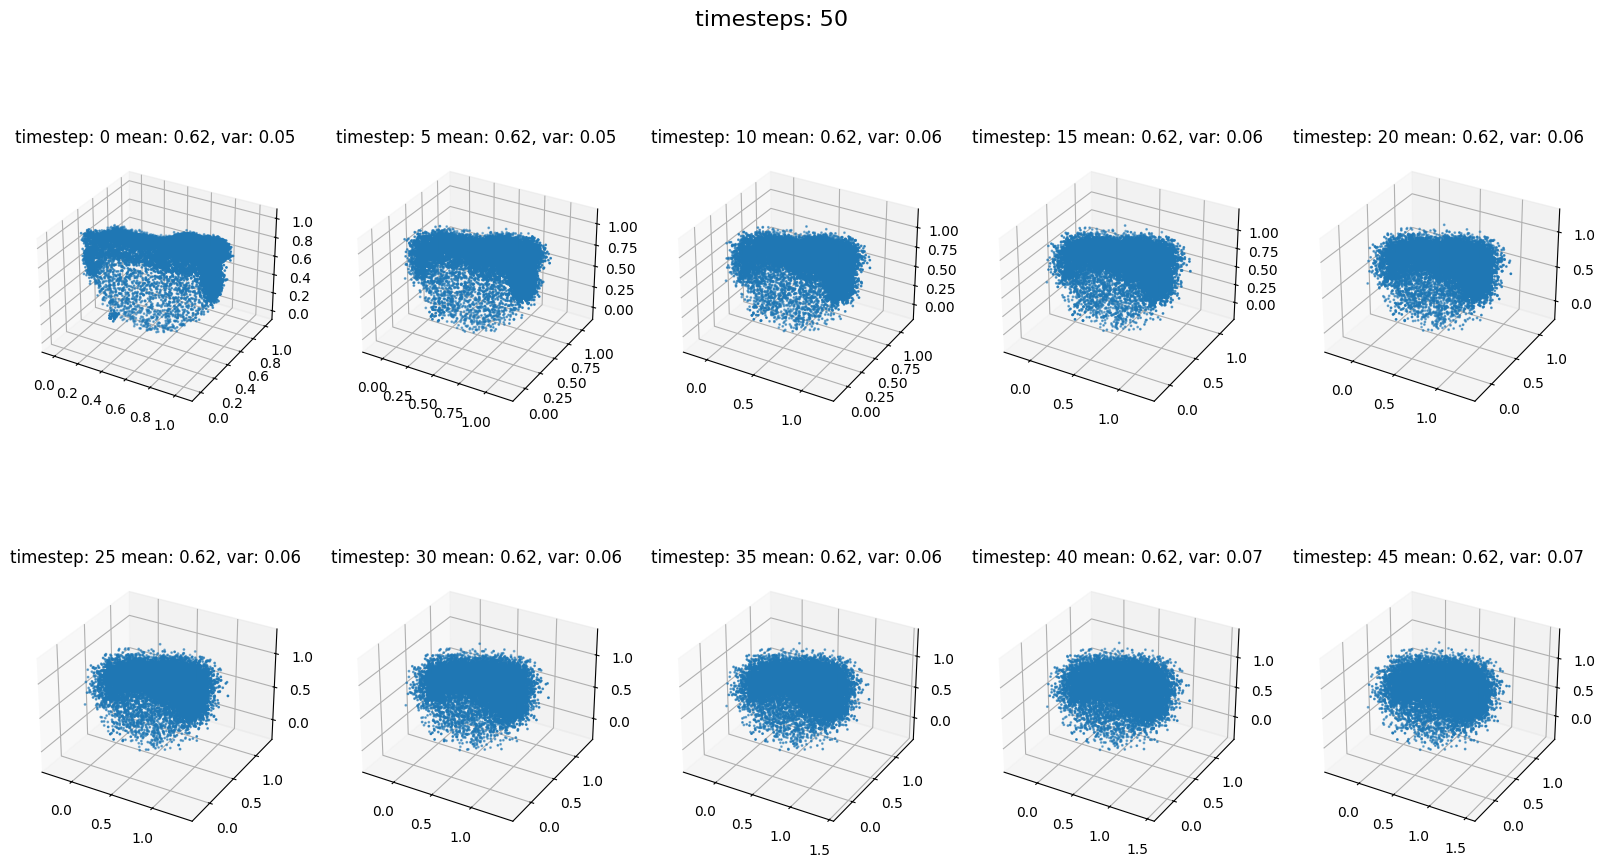

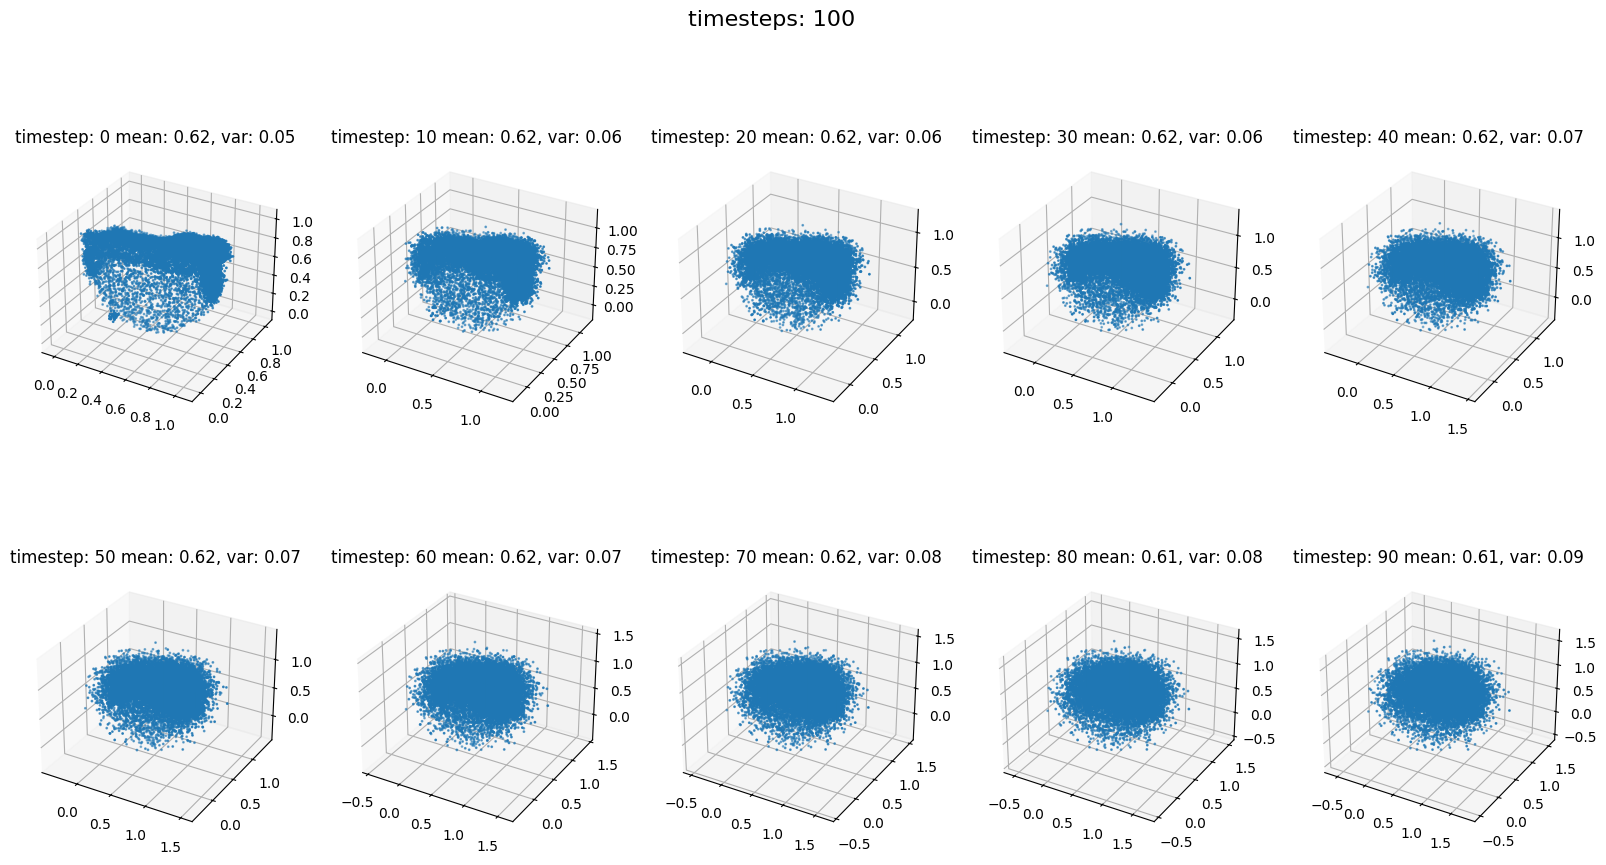

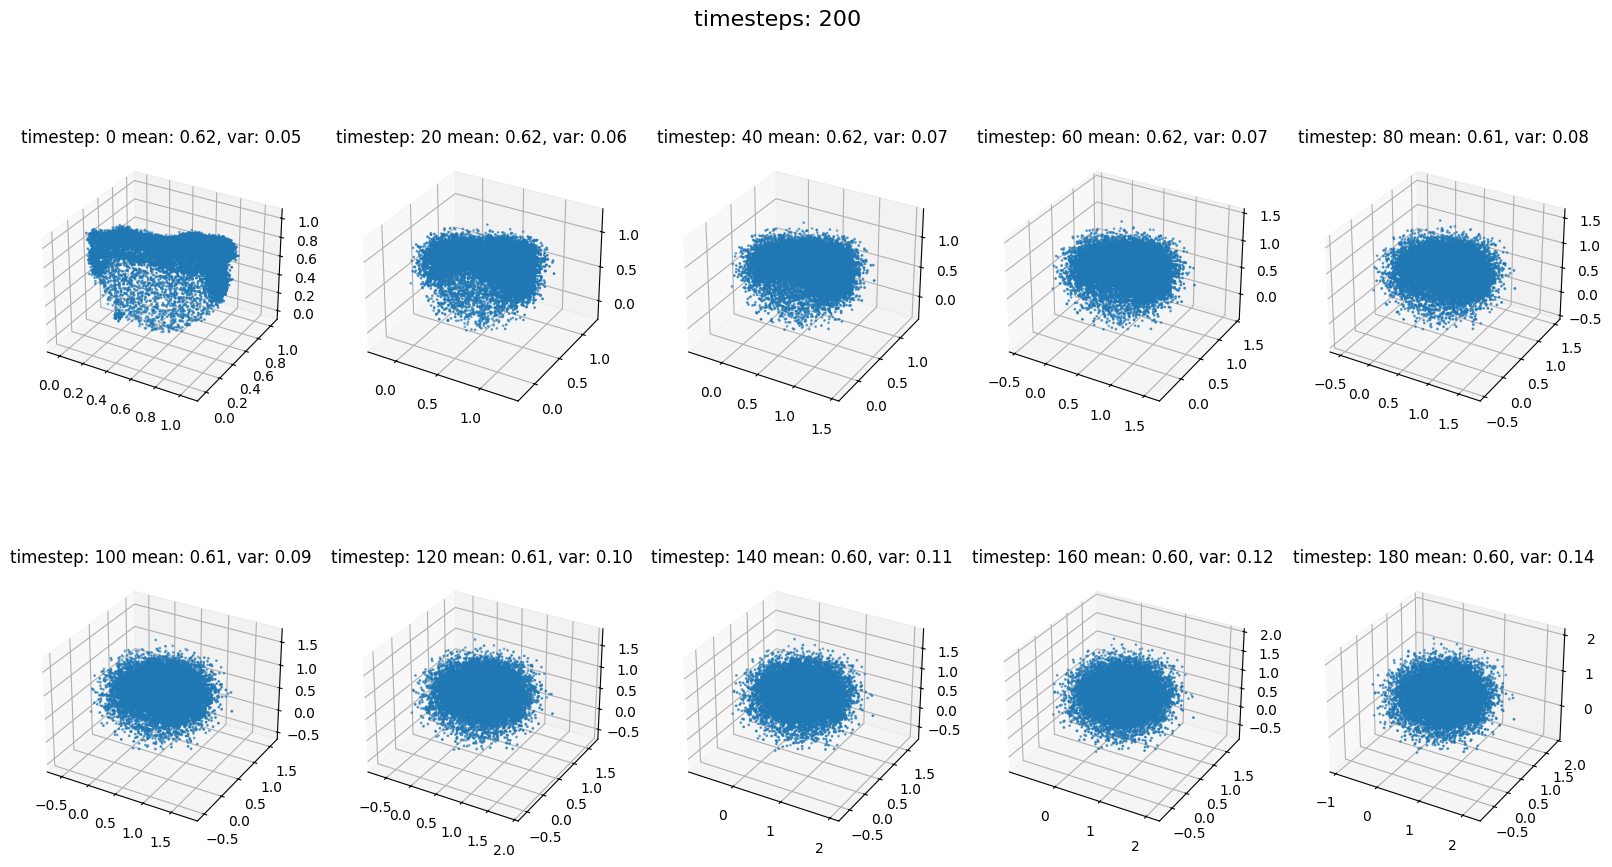

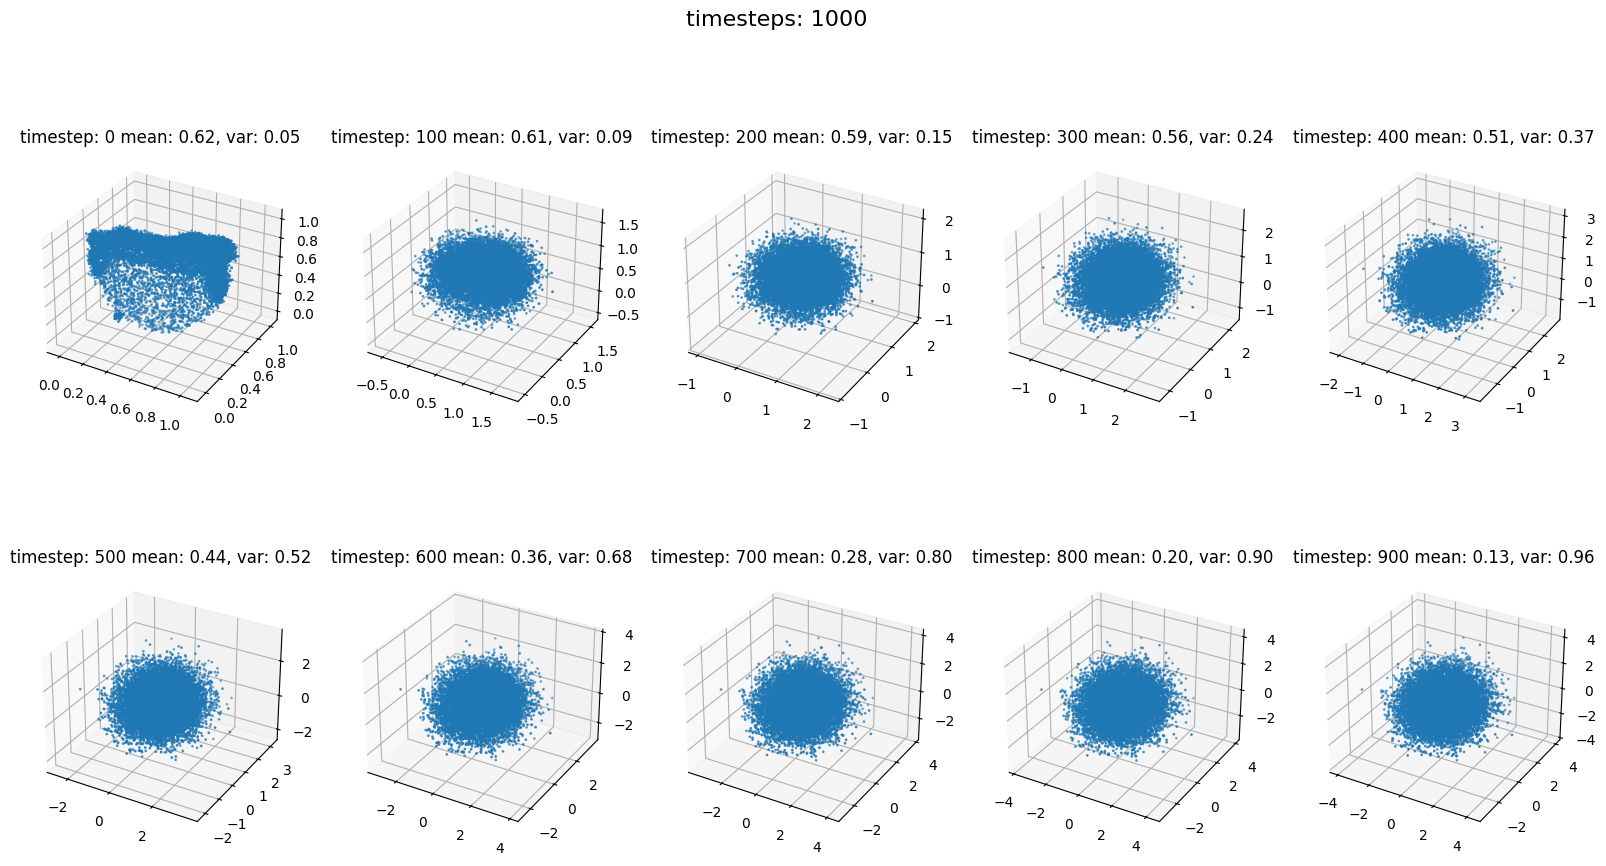

In [14]:
import torch

# plot influence of denoising timesteps
timesteps = [10, 50, 100, 200, 1000]

# get x0 and normalize to [-1, 1]
x0 = x 
x0 = x0 - np.min(x0, axis=0)
x0 = x0 / np.max(x0, axis=0)
x0 = torch.from_numpy(x0).float().unsqueeze(0)

epsilon = torch.randn_like(x0)


for tglobal in timesteps:
    cfg.diffusion.num_timesteps = tglobal
    diffusion = GaussianDiffusion(cfg)
    samples = torch.tensor([])
    
    for t in np.arange(0, tglobal, tglobal//10):
        t = torch.tensor(t).reshape(1,).long()
        qsample = diffusion.q_sample(x0, t=t, noise=epsilon)
        samples = torch.cat((samples, qsample), dim=0)
    
    # plot samples next to each other
    fig = plt.figure(figsize=(20, 10))
    
    # set title
    fig.suptitle(f"timesteps: {tglobal}", fontsize=16)
    for i in range(10):
        samp = samples[i, :, :].detach().numpy()
        ax = fig.add_subplot(2, 5, i+1, projection='3d')
        ax.scatter(samp[:, 0], samp[:, 1], samp[:, 2], s=1)
        # calculate mean and var
        mean = np.mean(samp)
        var = np.var(samp)
        # set title
        ax.set_title(f"timestep: {i * tglobal//10} mean: {mean:.2f}, var: {var:.2f}")
    

# Datasets

In [15]:
from data.scannetpp import ScanNetPPCut

In [ ]:
!export CUDA_HOME=/usr/local/cuda-11.7

In [ ]:
from data.dataloader import get_dataloader
from omegaconf import OmegaConf

In [ ]:
conf = "configs/overfit_room.yml"
opt = OmegaConf.load(conf)
opt.data.dataset = "Indoor"
opt.data.npoints = 2**14
opt.distribution_type = "single"
dl, *_ = get_dataloader(opt)

In [ ]:
batch = next(iter((dl)))
data = batch["train_points"]
lowres = batch["train_points_lowres"]
data.shape, data.min(), data.max(), data.mean(), data.std()

In [ ]:
import pyviz3d.visualizer as viz

ps = 2

v = viz.Visualizer()
v.add_points("hires", data[1, ...].numpy(), point_size=ps, visible=False)
v.add_points("lowres", lowres[1, ...].numpy(), point_size=ps, visible=True)
v.save("test")

In [ ]:
from data.utils import concat_nn
import torch

In [ ]:
%%time
x1 = torch.randn(100000, 3)
x2 = torch.randn(100000, 3)
y = concat_nn(x1, x2)

In [ ]:
model = PVCLion(out_dim=3, input_dim=3, embed_dim=16, npoints=1_000_000, use_att=False, extra_feature_channels=3, dropout=0.1).cuda()
# print number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1_000_000}M")

In [ ]:
class DotDict(dict):
    """
    a dictionary that supports dot notation 
    as well as dictionary access notation 
    usage: d = DotDict() or d = DotDict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value

In [ ]:
from minkowski.minkunet import ResUNet14, TinyUnet

config = DotDict
config.bn_momentum = 0.9
config.conv1_kernel_size = 7

model = TinyUnet(in_channels=3, out_channels=3, config=config, D=3).cuda()
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1_000_000}M")

In [ ]:
ds = IndoorScenes(root_dir="../../3d/", npoints=1_000_000)

In [ ]:
data = ds[0]

pcond = data["train_points_lowres"].unsqueeze(0).cuda()
noise = torch.randn(1, 1_000_000, 3).cuda()
t = torch.rand(1).cuda()

# concat
#x = torch.cat([pcond, noise], dim=1)

In [ ]:
import MinkowskiEngine as ME

def to_parse_tensor(coords, feats=None, voxel_size=0.001):
    """
    Converts the input coordinates and features to a sparse tensor.

    Args:
        coords (torch.Tensor): The input coordinates.
        feats (torch.Tensor): The input features.
        voxel_size (float): The voxel size for scaling the coordinates.

    Returns:
        ME.SparseTensor: The sparse tensor with the converted coordinates and features.
    """
    # scaling
    coords = coords / voxel_size
    b, n, c = coords.shape
    
    if feats is None:
        feats = torch.zeros((b*n, 3)).to(coords.device)
    elif feats.ndim == 3:
        feats = feats.reshape(b*n, 3)

    stensor = ME.SparseTensor(
        features=feats, # Convert to a tensor
        coordinates=ME.utils.batched_coordinates([c for c in coords], dtype=torch.float32, device=coords.device),  # coordinates must be defined in a integer grid. If the scale
        quantization_mode=ME.SparseTensorQuantizationMode.UNWEIGHTED_AVERAGE  # when used with continuous coordinates, average features in the same coordinate
    )
    return stensor

In [ ]:
xs = to_parse_tensor(coords=noise, feats=noise, voxel_size=0.001)

In [ ]:
model(xs)

In [ ]:
# voxelization
from modules.voxelization import Voxelization
from modules import functional as F
import torch
from torch import nn

In [ ]:
testhr = torch.rand(1, 3, 2048).cuda()
testlr = testhr[:, :, ::128]

resolution = 4

vox = Voxelization(resolution=resolution, normalize=True, eps=0)


voxfhr, norm_coords_hr = vox(features=testhr, coords=testhr)
voxflr, norm_coords_lr = vox(features=testlr, coords=testlr)

devoxhr = F.trilinear_devoxelize(voxfhr, norm_coords_hr, resolution)
devoxlr = F.trilinear_devoxelize(voxflr, norm_coords_hr, resolution)


In [ ]:
voxfhr.shape, norm_coords_hr.shape

In [ ]:
class FeatureVoxelConcatenation(nn.module):
    def __init__(self, resolution):
        super().__init__()
        self.resolution = resolution
        self.vox = Voxelization(resolution=resolution, normalize=True, eps=0)

    def forward(self, x1_features, x2_features, x1_coords, x2_coords):
        vox_x1, nc_x1 = self.vox(features=x1_features, coords=x1_coords)
        vox_x2, nc_x2 = self.vox(features=x2_features, coords=x2_coords)

        devox_mixed = F.trilinear_devoxelize(vox_x2, nc_x1, self.resolution)

        return torch.cat([x1_features, devox_mixed], dim=1)


In [ ]:
devoxlr.shape

In [ ]:
voxflr.shape, voxfhr.shape

In [ ]:
voxchr

In [ ]:
test_vox.__len__()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
with autocast(cache_enabled=False):
    out = model(inputs=x, t=t)

# Torchsparse

In [ ]:
from torch import nn
import torch
from torchsparse import nn as spnn
from torchsparse.utils.quantize import sparse_quantize
from torchsparse.utils.collate import sparse_collate_fn

from torchsparse import SparseTensor

class TestModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
        self.net = nn.Sequential(
            spnn.Conv3d(3, 64, 3),
            spnn.BatchNorm(64),
            spnn.ReLU(True),
            nn.Linear(64, 64),
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

model = nn.Sequential(
        spnn.Conv3d(3, 32, 3),
        spnn.BatchNorm(32),
        spnn.ReLU(True),
        spnn.Conv3d(32, 64, 2, stride=2),
        spnn.BatchNorm(64),
        spnn.ReLU(True),
        spnn.Conv3d(64, 64, 2, stride=2, transposed=True),
        spnn.BatchNorm(64),
        spnn.ReLU(True),
        spnn.Conv3d(64, 32, 3),
        spnn.BatchNorm(32),
        spnn.ReLU(True),
        spnn.Conv3d(32, 10, 1),
    ).to("cuda")



In [ ]:
test_in = torch.randn(2048, 3).numpy()
coords, indices = sparse_quantize(test_in, 1e-3, return_index=True)
coords = torch.tensor(coords, dtype=torch.int)
feats = torch.tensor(test_in[indices], dtype=torch.float)
tensor = SparseTensor(coords=coords, feats=feats)

model(tensor)